# Load .mat file

In [1]:
import sandbox as sb
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os

In [2]:
filePath = '/Users/ivanaescobar/Dropbox/UT_CSEM_2016-202*/research/crios_research/ARL_nesba/YT_data_fig_Sharp_ssp/'
if (os.uname()[0] == 'Linux'):
    filePath = '/scratch2/ivana/regionalgcm/data/'
fileName = 'Sharp_xshelf_ctd59-69.mat'
file = filePath + fileName

In [3]:
mat = sb.loadMatFile(file)
keys_to_remove = ("__header__", "__version__", "__globals__")
for k in keys_to_remove:
    mat.pop(k, None)

In [4]:
print(type(mat))
print(mat.keys())

<class 'dict'>
dict_keys(['ibdpth', 'idpth', 'ilat', 'ilon', 'isalt', 'isvcm', 'itemp', 'lat', 'lon', 'salt', 'sname', 'svcm', 'temp'])


In [5]:
mat['lat'].shape

(1, 11)

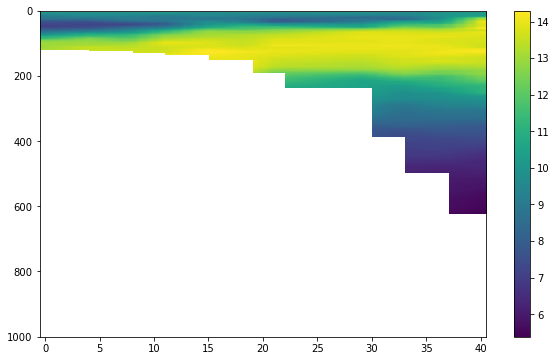

In [6]:
plt.figure(figsize=(10,6))
plt.imshow(mat["itemp"], aspect="auto")
plt.colorbar()

# Convert to xarray DataSet

modify dictionary to use **from_dict** xarray method

only saving:
- *ibdpth*: Dimension of dataSet
- *idpth*: Dimension of dataSet
- *ilat*: unused latitutdes 
- *ilon*: unused longitutdes 
- *isalt*: Data variable salinity
- *isvcm*: Data variable sound speed
- *itemp*: Data variable temperature

Other info: 
* Send source signature from TM4 experiment for time series modeling : \
TM4 source 4 second long chirp, bandwidth 775 Hz – 475 Hz.  Source depth:  81 m \
* Send lat, lon, depth coordinates of TM4 and AT: \
TM4:  39° 50.8542'N 70° 54.0876'W;  \
AT:  39° 57.150'N   70° 53.167'W

In [7]:
import xarray as xr

In [12]:
def makeDataSet (matlabDictionary):
    # IN: MATLab mat file loaded,
    # OUT: ds DataSet
    
    r = [len(matlabDictionary["ibdpth"])-i-1 for i in range(len(matlabDictionary["ibdpth"]))]
    z = [i for i in range(len(matlabDictionary["idpth"]))]
    
    #calc distances
    ranges = [0]
    for rr in range(len(matlabDictionary["ibdpth"])-1):
        distance = sb.wgs84Distance(matlabDictionary["ilat"][0][rr],   matlabDictionary["ilon"][0][rr],
                                    matlabDictionary["ilat"][0][rr+1], matlabDictionary["ilon"][0][rr+1])
        ranges.append( ranges[-1] + distance / 1000. )
    ranges.reverse()
    
    d = {
        "r":     {"dims": ("r"),     "data":r},
        "z":     {"dims": ("z"),     "data":z},
        "range": {"dims": ("r"),     "data":ranges},
        "depth": {"dims": ("r"),     "data":list(matlabDictionary["ibdpth"].flat)},
        "lat":   {"dims": ("r"),     "data":list(matlabDictionary["ilat"].flat)},
        "lon":   {"dims": ("r"),     "data":list(matlabDictionary["ilon"].flat)},
        "salt":  {"dims": ("z","r"), "data":matlabDictionary["isalt"].tolist()},
        "temp":  {"dims": ("z","r"), "data":matlabDictionary["itemp"].tolist()},
        "ss":    {"dims": ("z","r"), "data":matlabDictionary["isvcm"].tolist()}
    }
    ds = xr.Dataset.from_dict(d)
    ds = ds.sortby('r')
    
    # Assign attributes
    ds.range.attrs['long_name'] = 'range'
    ds.range.attrs['unit'] = 'km'
    ds.z.attrs['long_name'] = 'depth'
    ds.z.attrs['unit'] = 'm'
    ds.depth.attrs['long_name'] = 'maximum depth'
    ds.depth.attrs['unit'] = 'm'
    ds.ss.attrs['long_name'] = 'sound speed'
    ds.ss.attrs['unit'] = 'm/s'
    
    return ds

def makeCTDDataSet (matlabDictionary):
    # IN: MATLab mat file loaded,
    # OUT: ds DataSet

    r = [i for i in range(matlabDictionary["lat"].shape[1])]
    z = [i for i in range(len(matlabDictionary["idpth"]))]

    #calc distances
    ranges = [0]
    for rr in range(matlabDictionary["lat"].shape[1]-1):
        distance = sb.wgs84Distance(matlabDictionary["lat"][0][rr],   matlabDictionary["lon"][0][rr],
                                    matlabDictionary["lat"][0][rr+1], matlabDictionary["lon"][0][rr+1])
        ranges.append( ranges[-1] + distance / 1000. )
    ranges.reverse()

    d = {
        "r":     {"dims": ("r"),     "data":r},
        "z":     {"dims": ("z"),     "data":z},
        "range": {"dims": ("r"),     "data":ranges},
        "lat":   {"dims": ("r"),     "data":list(matlabDictionary["lat"].flat)},
        "lon":   {"dims": ("r"),     "data":list(matlabDictionary["lon"].flat)},
        "salt":  {"dims": ("z","r"), "data":matlabDictionary["salt"].tolist()},
        "temp":  {"dims": ("z","r"), "data":matlabDictionary["temp"].tolist()},
        "ss":    {"dims": ("z","r"), "data":matlabDictionary["svcm"].tolist()}
    }
    ds = xr.Dataset.from_dict(d)
    ds = ds.sortby('r')

    # Assign attributes
    ds.range.attrs['long_name'] = 'range'
    ds.range.attrs['unit'] = 'km'
    ds.z.attrs['long_name'] = 'depth'
    ds.z.attrs['unit'] = 'm'
    ds.ss.attrs['long_name'] = 'sound speed'
    ds.ss.attrs['unit'] = 'm/s'
    
    return ds

In [13]:
ds    = makeDataSet(mat)
dsCTD = makeCTDDataSet(mat)

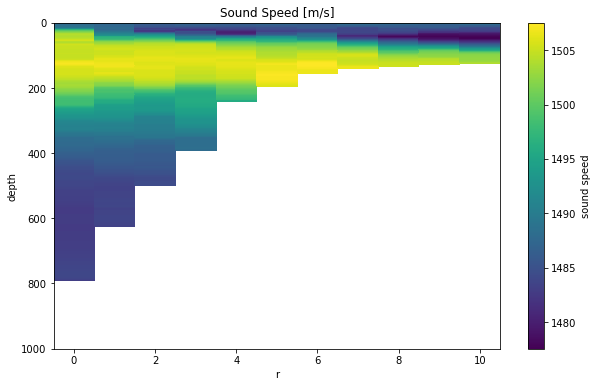

In [14]:
plt.figure(figsize=(10,6))
dsCTD.ss.plot(yincrease=False)
plt.title('Sound Speed [m/s]');

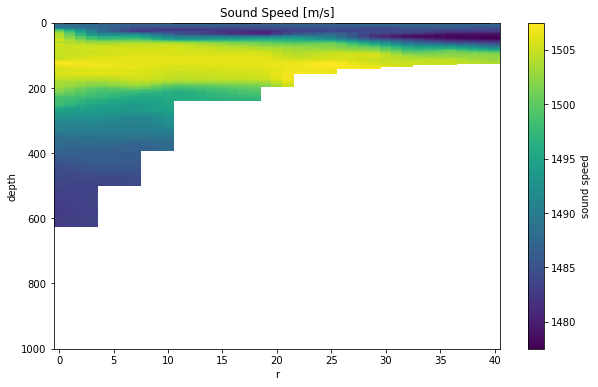

In [9]:
plt.figure(figsize=(10,6))
ds.ss.plot(yincrease=False)
plt.title('Sound Speed [m/s]');

In [10]:
ds

<xarray.Dataset>
Dimensions:  (r: 41, z: 1001)
Coordinates:
  * r        (r) int64 0 1 2 3 4 5 6 7 8 9 10 ... 31 32 33 34 35 36 37 38 39 40
  * z        (z) int64 0 1 2 3 4 5 6 7 8 ... 993 994 995 996 997 998 999 1000
Data variables:
    range    (r) float64 0.0 1.028 2.056 3.084 4.112 ... 38.25 39.28 40.3 41.32
    depth    (r) float64 872.3 814.3 759.3 695.3 ... 130.1 128.5 127.1 125.7
    lat      (r) float64 39.85 39.86 39.87 39.88 ... 40.19 40.2 40.21 40.22
    lon      (r) float64 -70.89 -70.88 -70.88 -70.88 ... -70.91 -70.91 -70.91
    salt     (z, r) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    temp     (z, r) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ss       (z, r) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

# Save data set to netcdf

In [15]:
runName = 'nesba-tm4'
if (os.uname()[0] == 'Linux'):
    runName = 'nesba-tm4_sverdrup'
ds.to_netcdf(filePath+runName+'.nc')
dsCTD.to_netcdf(filePath+runName+'_CTD.nc')

<sub> Written by Ivana Escobar on June 2022